# Movie Recommendation System

## Data EDA & Preprocessing

### 1. Install Required Packages

In [11]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 2. Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import groq
from dotenv import load_dotenv
from enum import Enum
from pydantic import BaseModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

True

### 3. EDA

In [13]:
df = pd.read_csv('data/raw/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [14]:
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
df.info()

Shape of dataset: (34886, 8)

Column names:
 ['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Genre', 'Wiki Page', 'Plot']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [17]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nNumber of duplicated rows:", df.duplicated().sum())


Missing values per column:
 Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

Number of duplicated rows: 0


### 4. Data Preprocessing

In [22]:
df['Director'] = df['Director'].replace("Unknown", pd.NA)
df['Director'] = df['Director'].fillna("unknown_director")
df['Cast'] = df['Cast'].fillna("unknown_cast")

In [3]:
class Genre(str, Enum):
    ACTION = "Action"
    COMEDY = "Comedy"
    HORROR = "Horror"
    THRILLER = "Thriller"
    ANIMATION = "Animation"
    ADVENTURE = "Adventure"
    BIOGRAPHY = "Biography"
    ROMANCE = "Romance"
    DRAMA = "Drama"

class GenrePrediction(BaseModel):
    plot: str
    pred_genre: Genre

def predict_genre(
        plot: str
        ):

    prompt = f"""
                 What is the most likely genre (Action, Comedy, Drama, Horror, Thriller, Animation, Adventure, Biography, Romance, etc.) for the following plot: '{plot}' ?

                 Your response only consist of one word: Action, Comedy, Drama, Horror, Thriller, Animation, Adventure, Biography, Romance, etc.
                 """
    
    response = groq.Groq().chat.completions.create(
                                                   model="llama3-70b-8192",
                                                    messages=[{
                                                        "role": "user", 
                                                        "content": prompt
                                                        }]
                                                    )

    predict_genre = response.choices[0].message.content.strip()
    return predict_genre

In [ ]:
df['Genre'] = df['Genre'].replace("unknown", pd.NA)
missing_genre_index = df['Genre'].isnull()
for idx in df[missing_genre_index].index:
    plot = df.loc[idx, 'Plot']
    genre = predict_genre(plot)
    if genre:
        df.loc[idx, 'Genre'] = genre
        print(f"{plot} : {genre}")
    else:
        print(f"{plot} : No Genre Detected")


Movies per binned year group:

Year Binned
1900s      309
1920s     2981
1940s     6333
1960s     5016
1980s     7687
2000s    12560
Name: count, dtype: int64


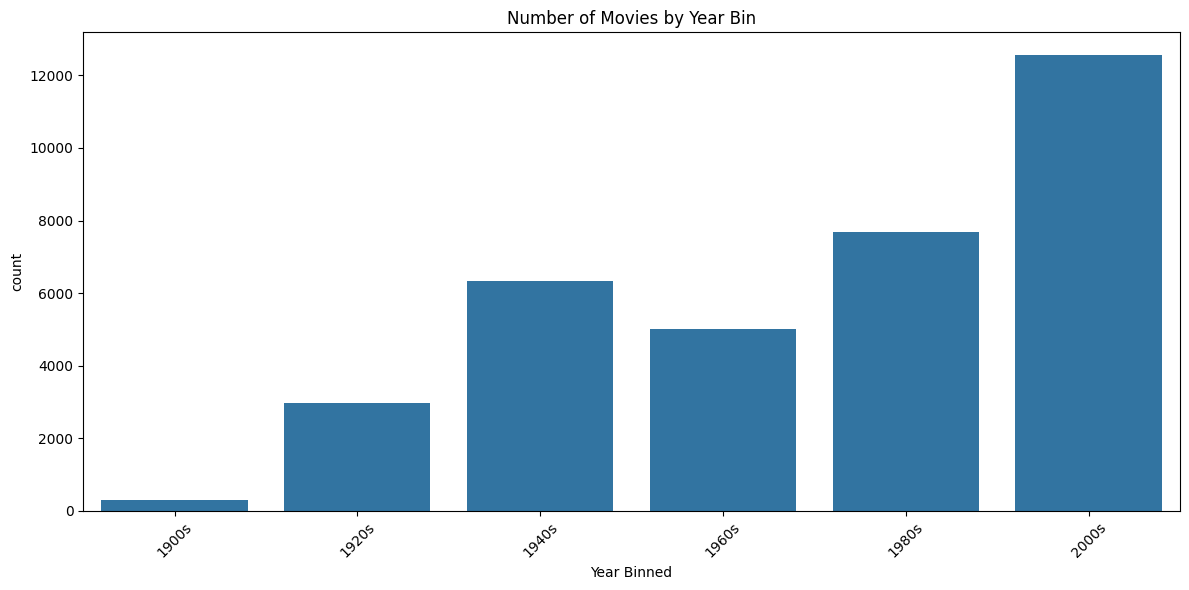

In [20]:
bins = list(range(1900, 2021, 20)) 
labels = [f"{b}s" for b in bins[:-1]]  

df['Year Binned'] = pd.cut(df['Release Year'], bins=bins, labels=labels, right=False)

print("\nMovies per binned year group:\n")
print(df['Year Binned'].value_counts().sort_index())

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Year Binned', order=labels)
plt.title("Number of Movies by Year Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns=[
                        'Wiki Page', 'Release Year', 'Plot'
                        ])
df.head()

,Title,Origin/Ethnicity,Director,Cast,Genre,Year Binned
0,Kansas Saloon Smashers,American,Unknown,NaN,Comedy,1900s
1,Love by the Light of the Moon,American,Unknown,NaN,Romance,1900s
2,The Martyred Presidents,American,Unknown,NaN,Thriller,1900s
3,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,Comedy.,1900s
4,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,Fantasy/Adventure,1900s


In [27]:
df.to_csv('data/processed/Movies_Preprocessed.csv', index=False)

### 5. Feature Engineering

In [29]:
df = pd.read_csv("data/processed/Movies_Preprocessed.csv")

df.head(5)

,Title,Origin/Ethnicity,Director,Cast,Genre,Year Binned
0,Kansas Saloon Smashers,American,Unknown,NaN,Comedy,1900s
1,Love by the Light of the Moon,American,Unknown,NaN,Romance,1900s
2,The Martyred Presidents,American,Unknown,NaN,Thriller,1900s
3,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,Comedy.,1900s
4,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,Fantasy/Adventure,1900s


In [5]:
def clean_text(x):
    return str(x).replace(" ", "").lower()

df["combined_features"] = (
    df["Origin/Ethnicity"].apply(clean_text) + " " +
    df["Director"].apply(clean_text) + " " +
    df["Cast"].apply(clean_text) + " " +
    df["Year Binned"].apply(clean_text) + " " +
    df["Genre"].apply(clean_text)
)

### 6. Vectorization

In [6]:
tfidf = TfidfVectorizer(stop_words="english")

tfidf_matrix = tfidf.fit_transform(df["combined_features"])

print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (34886, 41076)


In [7]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Cosine similarity matrix shape:", cosine_sim.shape)

Cosine similarity matrix shape: (34886, 34886)


### 7. Recommendation Function

In [36]:
df = df.reset_index()
df["Title_Clean"] = df["Title"].str.lower().str.strip()

indices = pd.Series(df.index, index=df["Title_Clean"])

def recommend_movies(title, n=10):
    #title = title.lower()
    title = title.lower().strip()
    if title not in indices:
        return ["Movie not found in dataset."]
    
    idx = indices[title]

    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]
        
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]   # exclude first (itself)
    movie_indices = [i[0] for i in sim_scores]
    return df["Title"].iloc[movie_indices].tolist()


In [37]:
print(recommend_movies("the dark knight", 5))

['The Dark Knight', 'Batman Begins', 'Dark Knight Rises, TheThe Dark Knight Rises', 'The Dark Knight Rises', 'The Prestige']
